# Проект: классификация

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
import plotly.express as px

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [51]:
data = pd.read_csv('Data/bank_fin.csv', sep = ';')
data.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [52]:
# исследуйте данные на предмет пропусков.
# Где есть пропущенные значения? Сколько их?
data.info()
data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [53]:
# есть ли в признаке job пропущенные значения?
# Возможно, они обозначены каким-то специальным словом?

print(data['job'].value_counts())

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64


### Задание 3

In [54]:
# преобразуйте признак balance таким образом, чтобы
# он корректно считывался, как вещественное число (float)

data['balance'] = data['balance'].astype(str)

data['balance']  = data['balance'].apply(
    lambda x: str(x.replace("$","").replace(" ", "").split(',')[0]))
data['balance'] = data['balance'].astype(float)
print(round(data['balance'].mean(), 3))

data.head(5)

1529.129


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes


### Задание 4

In [55]:
# обработайте пропуски в признаки balance,
# заменив их на медианные значения по данному признаку:

data['balance'].fillna(data['balance'].median(), inplace=True)
print(round(data['balance'].mean(), 3))

1526.936


### Задание 5

In [56]:
# обработайте пропуски в категориальных признаках
# job и education, заменив их на модальные значения:

mode_job = data['job'].mode()
mode_ed = data['education'].mode()

data['job'] = data['job'].replace('unknown', 'management')
data['education'] = data['education'].replace('unknown', 'secondary')

av_balance = data[(data['job'] == 'management') & (data['education'] == 'secondary')]['balance'].mean()
print(round(av_balance, 3))

1598.883


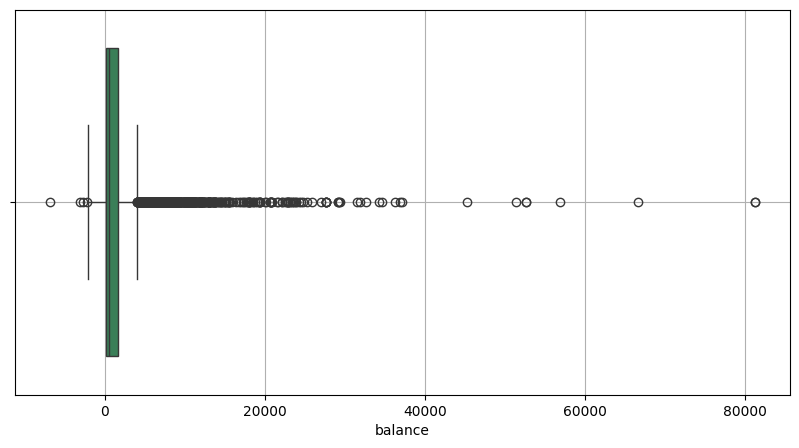

In [57]:
fig = plt.figure(figsize = (10, 5))
boxplot = sns.boxplot(
    data = data,
    x = 'balance',
    orient = 'h',
    color = 'seagreen'
)
boxplot.grid()

In [58]:
x = data['balance']
Q1 = np.percentile(x, 25)
Q3 = np.percentile(x, 75)
IQR = Q3 - Q1
L = (Q1 - 1.5 * IQR)
U = (Q3 + 1.5 * IQR)
print(L, U)

# q1 = data['balance'].quantile(0.25)
# q3 = data['balance'].quantile(0.75)
# iqr = q3 - q1
# df = data[(data['balance'] < q3 + 1.5 * iqr) & (data['balance'] > q1 - 1.5 * iqr)]


-2241.0 4063.0


### Задание 6

In [59]:
# удалите все выбросы для признака balance:

display(data['balance'].describe())

count    11162.000000
mean      1526.936033
std       3224.829691
min      -6847.000000
25%        123.000000
50%        550.000000
75%       1699.000000
max      81204.000000
Name: balance, dtype: float64

In [60]:
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

In [61]:
outliers, cleaned = outliers_iqr(data, 'balance')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105


In [62]:
display(data['balance'].describe())

count    11162.000000
mean      1526.936033
std       3224.829691
min      -6847.000000
25%        123.000000
50%        550.000000
75%       1699.000000
max      81204.000000
Name: balance, dtype: float64

## Часть 2:  Разведывательный анализ

### Задание 1

In [63]:
# изучите соотношение классов в ваших данных на предмет несбалансированности,
# проиллюстрируйте результат

data['age'].max()
data['job'].value_counts()
display(data['deposit'].describe())
data['deposit'].value_counts()

count     11162
unique        2
top          no
freq       5873
Name: deposit, dtype: object

deposit
no     5873
yes    5289
Name: count, dtype: int64

In [64]:
px.histogram(data,
             x = 'deposit',
             # Выведем количество наблюдений в каждом столбце:
             text_auto = True,
             # Цвет графика:
             color_discrete_sequence = ['seagreen'],
             # Высота графика:
             height = 400,
             # Заголовок графика: 
             title = '''Количество клиентов открывших депозит:'''
             )

### Задания 2 и 3

In [65]:
# рассчитайте описательные статистики для количественных переменных,
# проинтерпретируйте результат

data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1526.936033,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,3224.829691,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,123.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,1699.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


### Задания 4 и 5

In [66]:
# рассчитайте описательные статистики для категориальных переменных,
# проинтерпретируйте результат

data.describe(include = 'object')

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,11162,11162,11162,11162,11162,11162,11162,11162,11162,11162
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2636,6351,5973,10994,5881,9702,8042,2824,8326,5873


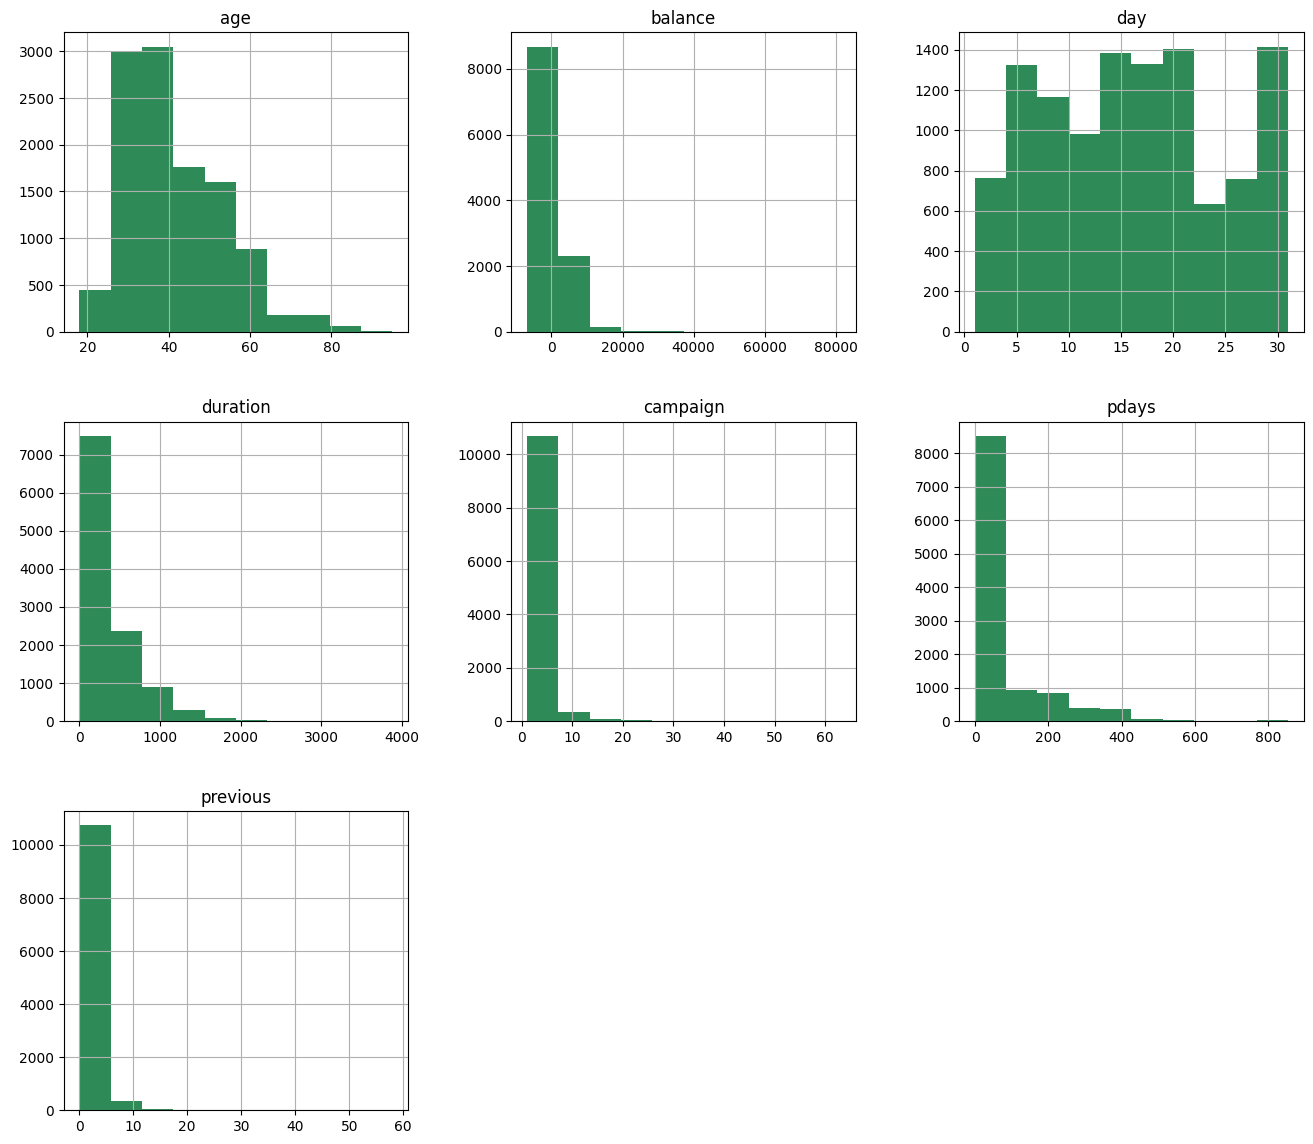

In [67]:
# постройте визуализации, иллюстрирующие результаты
data.hist(figsize = (16,14),
          # Цвет графика:
          color = ['seagreen'])             
fig.show()

### Задание 6

In [68]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании
# успех в текущей превалирует над количеством неудач.

types = data.groupby('poutcome')['deposit'].value_counts().unstack()

fig = px.bar(types,
    barmode = 'group',
    # Цвет графика:
    color_discrete_sequence = ['lightgreen', 'seagreen'],
    # Высота графика:
    height = 500,
    # Выведем количество наблюдений в каждом столбце:
    text_auto = True
    )

# Присваиваем заголовки осей координат:
fig.update_xaxes(title_text = 'Статус предыдущей маркетинговой кампании:')
fig.update_yaxes(title_text = 'Количество клиентов:')
# Выводим результат на экран:    )             
fig.show()

### Задание 7

In [69]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит

data['month'].value_counts()

month
may    2824
aug    1519
jul    1514
jun    1222
nov     943
apr     923
feb     776
oct     392
jan     344
sep     319
mar     276
dec     110
Name: count, dtype: int64

### Задание 8

In [70]:
# Создайте возрастные группы и определите, в каких группах более
# склонны открывать депозит, чем отказываться от предложения:

bin_labels_5 = ['<30', '30-40', '40-50', '50-60', '60+']

data['AgeCategory'] = pd.qcut(data['age'],
                              q = 5,
                              labels = bin_labels_5)
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,AgeCategory
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,60+
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,60+
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,40-50
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes,60+
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes,60+


In [71]:
pivot_age = data.pivot_table(
    index = 'AgeCategory',
    columns = 'deposit',
    values = 'campaign',    
    aggfunc = 'count')

# Построим многоуровневую столбчатую диаграмму:
fig = px.bar(pivot_age,
    barmode = 'group',
    # Заголовок графика:
    title = '''возрастные группы склонные открывать депозит:''',
    # Цвет графика:
    color_discrete_sequence = ['lightgreen', 'seagreen'],
    # Высота графика:
    height = 500,
    # Выведем количество наблюдений в каждом столбце:
    text_auto = True
    )
# Присваиваем заголовки осей координат:
fig.update_xaxes(title_text = 'Возраст клиентов:')
fig.update_yaxes(title_text = 'Количество клиентов:')
# Выводим результат на экран:
fig.show()

### Задания 9 и 10

In [72]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости
# от семейного статуса

data.groupby('deposit')['marital'].value_counts()

deposit  marital 
no       married     3596
         single      1606
         divorced     671
yes      married     2755
         single      1912
         divorced     622
Name: count, dtype: int64

In [73]:
# Создаем сводную таблицу:

df_deposit = data.pivot_table(index = 'marital',
    columns = 'deposit',
    values = 'job',
    aggfunc = 'count'
    )

# Построим многоуровневую столбчатую диаграмму:
fig = px.bar(df_deposit,
    barmode = 'group',
    # Заголовок графика:
    title = '''Зависимость открывших и неоткрывших депозит от семейного статуса:''',
    # Цвет графика:
    color_discrete_sequence = ['lightgreen', 'seagreen'],
    # Высота графика:
    height = 500,
    # Выведем количество наблюдений в каждом столбце:
    text_auto = True
    )
# Присваиваем заголовки осей координат:
fig.update_xaxes(title_text = 'Количество депозитов:')
fig.update_yaxes(title_text = 'Количество клиентов:')
# Выводим результат на экран:
fig.show()

In [74]:
# постройте визуализации для открывших и неоткрывших депозит
# в зависимости от образования:

data.groupby('deposit')['education'].value_counts()

deposit  education
no       secondary    3271
         tertiary     1693
         primary       909
yes      secondary    2702
         tertiary     1996
         primary       591
Name: count, dtype: int64

In [75]:
# Создаем сводную таблицу:

df_education = data.pivot_table(index = 'education',
    columns = 'deposit',
    values = 'job',
    aggfunc = 'count'
    )

# Построим многоуровневую столбчатую диаграмму:
fig = px.bar(df_education,
    barmode = 'group',
    # Заголовок графика:
    title = '''Зависимость открывших и неоткрывших депозит от образования:''',
    # Цвет графика:
    color_discrete_sequence = ['lightgreen', 'seagreen'],
    # Высота графика:
    height = 500,
    # Выведем количество наблюдений в каждом столбце:
    text_auto = True
    )
# Присваиваем заголовки осей координат:
fig.update_xaxes(title_text = 'Количество депозитов:')
fig.update_yaxes(title_text = 'Количество клиентов:')
# Выводим результат на экран:
fig.show()

In [76]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости
# от вида профессиональной занятости:

data.groupby('deposit')['job'].value_counts()

deposit  job          
no       management       1301
         blue-collar      1236
         technician        983
         admin.            703
         services          554
         retired           262
         self-employed     218
         entrepreneur      205
         housemaid         165
         unemployed        155
         student            91
yes      management       1335
         technician        840
         blue-collar       708
         admin.            631
         retired           516
         services          369
         student           269
         unemployed        202
         self-employed     187
         entrepreneur      123
         housemaid         109
Name: count, dtype: int64

In [77]:
# Создаем сводную таблицу:

df_job = data.pivot_table(index = 'job',
    columns = 'deposit',
    values = 'education',
    aggfunc = 'count'
    )

# Построим многоуровневую столбчатую диаграмму:
fig = px.bar(df_job,
    barmode = 'group',
    # Заголовок графика:
    title = '''Зависимость открывших и неоткрывших
депозит от вида профессии:''',
    # Цвет графика:
    color_discrete_sequence = ['lightgreen', 'seagreen'],
    # Высота графика:
    height = 500,
    # Выведем количество наблюдений в каждом столбце:
    text_auto = True
    )
# Присваиваем заголовки осей координат:
fig.update_xaxes(title_text = 'Количество депозитов:')
fig.update_yaxes(title_text = 'Количество клиентов:')
# Выводим результат на экран:
fig.show()

### Задание 11

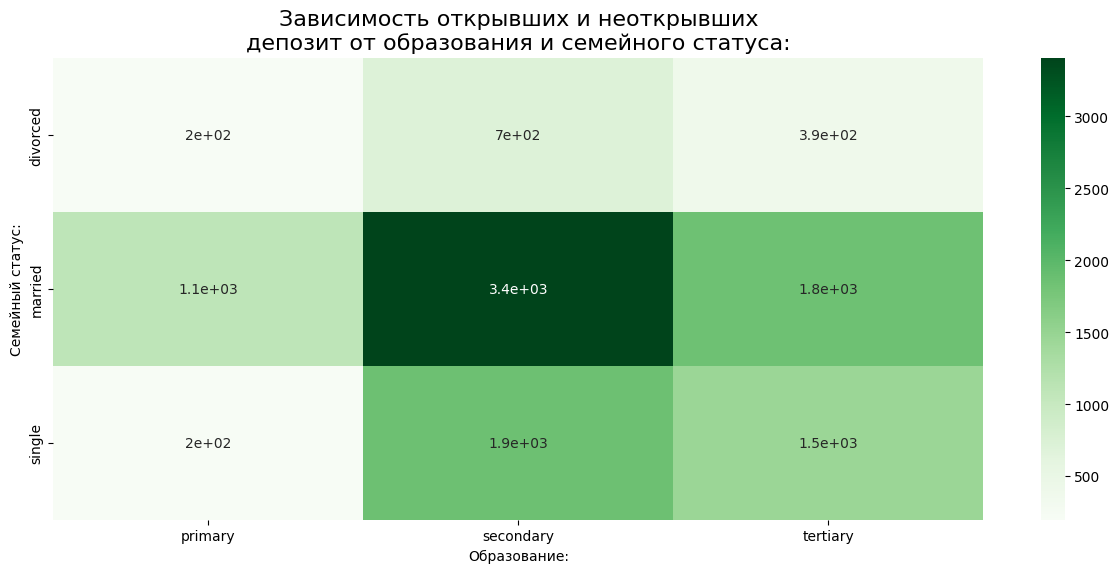

In [78]:
# постройте сводную таблицу, чтобы определить люди с каким образованием
# и семейным статусом наиболее многочисленны
# (если рассматривать тех, кто открыл депозит)

# pivot = data.groupby('deposit')[['education', 'marital']].value_counts()

# Создаем сводную таблицу:

pivot = data.pivot_table(index = 'marital',
    columns = 'education',
    values = 'deposit',
    aggfunc = 'count'
    )

# На основе полученной сводной таблицы построим
# тепловую карту с аннотацией:
fig = plt.figure(figsize = (15, 6))
heatmap = sns.heatmap(data = pivot, annot = True, cmap = 'Greens')
# Заголовок графика:
heatmap.set_title('''Зависимость открывших и неоткрывших
депозит от образования и семейного статуса:''', fontsize = 16)
# Присваиваем заголовки осей координат:
heatmap.set(xlabel = 'Образование:', ylabel = 'Семейный статус:')
# Выводим результат на экран:
plt.show()

## Часть 3: преобразование данных

### Задание 1

In [79]:
# Преобразуйте уровни образования:

labelencoder = LabelEncoder()

data['education'] = labelencoder.fit_transform(data['education'])
data['education'].sum()

13351

### Задания 2 и 3

In [80]:
# преобразуйте бинарные переменные в представление из нулей и единиц

# Кодируем признак 'deposit':
data['deposit'] = data['deposit'].map({"yes": 1, "no": 0})
print(round(data['deposit'].std(),3))

0.499


In [81]:
# Кодируем признак 'default':
data['default'] = data['default'].map({"yes": 1, "no": 0})
print(round(data['default'].mean(),3))

0.015


In [82]:
# Кодируем признак 'housing':
data['housing'] = data['housing'].map({"yes": 1, "no": 0})
print(round(data['housing'].mean(),3))

0.473


In [83]:
# Кодируем признак 'loan':
data['loan'] = data['loan'].map({"yes": 1, "no": 0})
print(round(data['loan'].mean(),3))

0.131


### Задание 4

In [84]:
# создайте дамми-переменные

### Задания 5 и 6

In [85]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности

### Задания 7 и 8

In [86]:
X = data.drop(['deposit'], axis=1)
y = data['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [87]:
# рассчитайте необходимые показатели

### Задание 9

In [88]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков

### Задание 10

In [89]:
# нормализуйте данные с помощью minmaxsxaler

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [90]:
# обучите логистическую регрессию и рассчитайте метрики качества

### Задания 2,3,4

In [91]:
# обучите решающие деревья, настройте максимальную глубину

### Задание 5

In [ ]:
# подберите оптимальные параметры с помощью gridsearch

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [ ]:
# обучите на ваших данных случайный лес

### Задания 2 и 3

In [ ]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

### Задание 4

In [ ]:
# объедините уже известные вам алгоритмы с помощью стекинга 

### Задание 5

In [ ]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

### Задания 6,7,8

In [ ]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna